In [30]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

### import data

# ris contain RIS data: Genome_ID - Drug - RIS
ris = pd.read_pickle("/home/hermuba/resistanceExp/data/anno_sps_df")
ris = ris.loc[ris['Species'] == 'Escherichia']
# df contain Genome_ID - cdhit(0101010)
df = pd.read_pickle("/home/hermuba/resistanceExp/EcoliGenomes/cdhitResult/ec0913_df")
# card contain Genome_ID - card_ARO(0101010)
card = pd.read_pickle('/home/hermuba/resistanceExp/data/aro_pattern_df')
# cluster_detail contain cdhit - prevalance - card
cluster_detail = pd.read_pickle("../../cdhitResult/cluster_detail_tmp1010")

In [31]:
#those drugs have nearly 50 data, therefore their data are selected for training
train_drug = ['meropenem', 'gentamicin', 'ciprofloxacin', 'trimethoprim/sulfamethoxaole', 'ampicillin', 'cefazolin']
                                                
### Function to join X with y
# Input: X(dataframe with Genome ID, 01010); y(Genome ID, RIS), abx(drug name)
    # X can be df(all genes), acc(accessory only), card(card AROs), card AND acc, card merge with acc
# Output: df(aligned Genome_ID - X - y)

def join_df(X, y, abx):
    # subset y
    ris_need = ris.loc[ris['Antibiotic'] == abx][['Genome ID', 'Resistant Phenotype']] 
    # join X with y
    df_ris = pd.merge(X, ris_need, left_index = True, right_on = "Genome ID")
    # reset_index to prevent problems with cross validation and train/test split. Drop the old index
    df_ris = df_ris.reset_index(drop = True)
    return(df_ris)

### Feature selection with existing knowledge
# select accessory genes
acc_index = cluster_detail.loc[cluster_detail['prevalance'] < 1].index
# select gene clusters that are identified by card
card_index = cluster_detail.loc[cluster_detail['card_portion'] > 0].index
#
acc_card_intersect_index = list(set(card_index) & set(acc_index))

### adding feature: merging two X dataframe
card_and_acc_X = pd.merge(card,df[acc_index], left_index = True, right_index = True)


In [32]:
# throw into naive bayes
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score     
def train_nb(df_ris):
    # hold out test set
    
    X_train, X_test, y_train, y_test = train_test_split(
        df_ris.drop(["Genome ID", "Resistant Phenotype"], axis = 1)
        , df_ris['Resistant Phenotype']
        , test_size=0.4 
        , random_state = 0) 
    ### i dont really know pseudo random status mean (please read about it), random status 20 yields best result?? 0.7
    ### it saids it is "random sampling test set but it is not (WTF)
    
    X_train.reset_index(inplace = True, drop = True)
    y_train.reset_index(inplace = True, drop = True)
    
    # seperate train and test into k fold
    n=10
    cv = ShuffleSplit(n_splits=n, test_size=0.3, random_state = 0)
    ### n_split = 10, test_size, does not change result; random_state yeilds best result 0.75
    
    
    # bnb.fit
    bnb = BernoulliNB()
    val_score = 0
    for train_index, test_index in cv.split(X_train, y_train):      
        bnb.fit(X_train.iloc[train_index,:], y_train[train_index])
        val = bnb.predict(X_train.iloc[test_index])
        score = accuracy_score(y_train[test_index], val)
        val_score = val_score + score
    
    v = val_score/n
    
    # model.predict()
    
    test = accuracy_score(y_test, bnb.predict(X_test))
    
    return([v,test])
   

In [33]:
from sklearn import svm
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold # this is the problem!!

    
def train_SVM(df):
    
    # split test, train
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(["Genome ID", "Resistant Phenotype"], axis = 1)
        , df['Resistant Phenotype']
        , test_size=0.4 
        , random_state = 0)
    
    # choose estimator (our model)
    clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
    
    # cross validation
    skf = StratifiedKFold(n_splits=3, random_state=None, shuffle=False)
    cv = skf.split(X_train, y_train)
   
    # tune hyperparameters
    gammas = np.logspace(-6, -1, 10)
    tuned_parameters = [{'kernel': ['rbf'], 'gamma': gammas,
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
    classifier = GridSearchCV(estimator=clf, cv=cv, param_grid=tuned_parameters)
    classifier.fit(X_train.values, np.asarray(y_train))
    
    v = classifier.cv_results_['mean_test_score'][classifier.best_index_]
    param = classifier.best_params_
    print(param)
    test = classifier.score(X_test, y_test)
    
    return([v,test])

In [91]:
# feature selection using pvalue
from scipy import stats
def p_value_list(df):
    r = df.loc[df['Resistant Phenotype'] == "Resistant"]
    not_r = df.loc[df['Resistant Phenotype'] != "Resistant"]
    
    p_value_ma = []
    for cluster_name in df.columns[:-2]:
        p_value = stats.ttest_ind(r[cluster_name], not_r[cluster_name])[1]
        p_value_ma.append(p_value)
    p = pd.Series(data = p_value_ma, index = df.columns[:-2])
    return(p.sort_values(ascending = True).index) # p value small are in the front

def p_feature_selection(complete_set, model):
    
    p = p_value_list(complete_set)
    t_matrix = []
    v_matrix = []
    feature = range(round(len(complete_set)/10),len(complete_set),round(len(complete_set)/10))
    print(feature)
    for a in feature:
        list_of_feature = list(p[0:a])
        list_of_col_name = list_of_feature + ['Resistant Phenotype', 'Genome ID']
        v, test = model(complete_set[list_of_col_name])
        t_matrix.append(test)
        v_matrix.append(v)
    plt.plot(feature,v_matrix,'r--',label = "val")
    plt.plot(feature,t_matrix,'b--', label = "test")
    plt.legend()
    plt.show()

range(6, 58, 6)


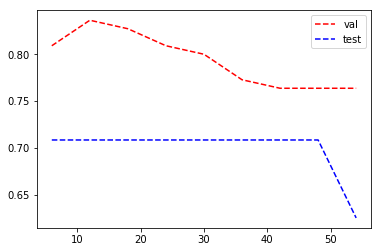

In [92]:
p_feature_selection(join_df(df,ris,'meropenem'), train_nb)

range(6, 58, 6)
{'C': 1, 'gamma': 0.02782559402207126, 'kernel': 'rbf'}
{'C': 1, 'gamma': 0.02782559402207126, 'kernel': 'rbf'}
{'C': 1, 'gamma': 0.10000000000000001, 'kernel': 'rbf'}
{'C': 1, 'gamma': 0.10000000000000001, 'kernel': 'rbf'}
{'C': 1, 'gamma': 0.10000000000000001, 'kernel': 'rbf'}
{'C': 1, 'gamma': 0.10000000000000001, 'kernel': 'rbf'}
{'C': 1, 'gamma': 0.10000000000000001, 'kernel': 'rbf'}
{'C': 10, 'gamma': 0.02782559402207126, 'kernel': 'rbf'}
{'C': 1, 'gamma': 0.10000000000000001, 'kernel': 'rbf'}


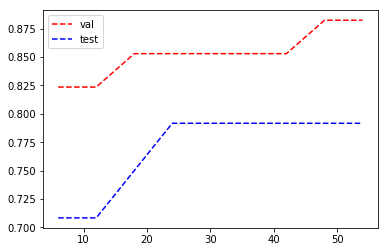

In [93]:
p_feature_selection(join_df(df,ris,'meropenem'), train_SVM)

In [73]:
plt.plot(t)

In [67]:
def run_all_condition(abx):
    result = pd.DataFrame(columns = ['model','feature','val', 'test'])
    model = {'naive-bayes':train_nb,
             'SVM':train_SVM}
    for i in range(len(model)):
        print(i)
        model_name = list(model.keys())[i]
        
        m = list(model.values())[i]
        # accessory
        result.loc[result.shape[0]+1] = [model_name,'accessory']+m(join_df(df[acc_index],ris,abx))
        # accessory intersect with card
        result.loc[result.shape[0]+1] = [model_name,'acc intersect aro']+m(join_df(df[acc_card_intersect_index],ris,abx))
        # card ARO
        result.loc[result.shape[0]+1] = [model_name,'card aro']+m(join_df(card,ris,abx))
    return(result)

    

In [68]:
run_all_condition('meropenem')

0
1
{'C': 1, 'gamma': 0.0077426368268112772, 'kernel': 'rbf'}
{'C': 100, 'gamma': 0.00059948425031894088, 'kernel': 'rbf'}


/home/hermuba/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:597: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


{'C': 10, 'gamma': 0.02782559402207126, 'kernel': 'rbf'}


,model,feature,val,test
1,naive-bayes,accessory,0.736364,0.541667
2,naive-bayes,acc intersect aro,0.654545,0.708333
3,naive-bayes,card aro,0.654545,0.416667
4,SVM,accessory,0.794118,0.708333
5,SVM,acc intersect aro,0.823529,0.750000
6,SVM,card aro,0.823529,0.791667
